In [ ]:
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
import pickle
from catboost import CatBoostClassifier


In [ ]:
train_df = pd.read_csv("data/data-3m.csv")
test_df = pd.read_csv("data/data-202008.csv")

In [ ]:
train_df.head()

,province_code,district_code,status_name,cust_name,msisdn,ben_cust_name,ben_msisdn,request_date,viettel_bank_code,channel_type_id,...,trans_amount,trans_fee,trans_type,process_code,channel_fee,shop_code,transfer_type,customer_fee,fee_partner,is_fraud
0,H031,H031007,NaN,NaN,000186ca85dea743c31b,NaN,NaN,2020-07-20T16:44:41.000+07:00,KPP,37.0,...,446151.0,909.0,3.0,W_KPP301,700.0,6100280135,NaN,0.0,1000.0,0
1,P210,P210009,Đã hoàn trả tiền vào TK BCCS,HA THI XUYEN,00018fc18afe4b9bffaa,HA NGOC LUYEN,00017da8a27b9b7974a4,2020-07-20T06:37:09.000+07:00,KPP,1.0,...,4000000.0,12273.0,4.0,KPP501,10800.0,1001344100_VTP,BCCS,27000.0,0.0,0
2,H019,H019001,NaN,Triệu Thị Hon,000135da6ed6e6692327,Triệu Thị Hon,000135da6ed6e6692327,2020-07-20T13:41:46.000+07:00,VTT,164.0,...,5000000.0,0.0,2.0,400100,7500.0,1800220009,NaN,0.0,0.0,0
3,H018,H018009,NaN,NaN,0001b6a32422e06151dd,NaN,NaN,2020-07-20T18:23:56.000+07:00,KPP,1.0,...,248677.0,909.0,3.0,KPP301,700.0,1001530100_VTP,NaN,0.0,1000.0,0
4,N350,N350003,NaN,NaN,000110bbafc5de415ba3,NaN,NaN,2020-07-20T20:16:01.000+07:00,KPP,1.0,...,461212.0,1000.0,3.0,KPP301,770.0,1001240100_VTP,NaN,0.0,1100.0,0


In [ ]:
from util import *

In [ ]:
cat_features = ["province_code", "district_code","viettel_bank_code","channel_code"
                ,"staff_code","process_code","shop_code"]

train_df = preprocess_data(train_df, cat_features)
test_df = preprocess_data(test_df, cat_features)

c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
y_train = train_df['is_fraud']
X_train = train_df.drop(['is_fraud'], axis = 1)
y_test = test_df['is_fraud']
X_test = test_df.drop(['is_fraud'], axis = 1)
    
X_train, X_val, y_train, y_val = train_test_split( X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
cat_model = CatBoostClassifier(
    iterations=2000,
    max_ctr_complexity=1,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=25,
    depth=6,
    task_type="GPU",
    loss_function="Logloss",
    eval_metric="AUC"
)

cat_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_val, y_val)
)

Learning rate set to 0.02343
0:	learn: 0.8460836	test: 0.8424678	best: 0.8424678 (0)	total: 412ms	remaining: 13m 43s
25:	learn: 0.9891628	test: 0.9895220	best: 0.9895220 (25)	total: 11.9s	remaining: 15m 7s
50:	learn: 0.9906257	test: 0.9909371	best: 0.9909371 (50)	total: 23.8s	remaining: 15m 9s
75:	learn: 0.9911477	test: 0.9914065	best: 0.9914117 (74)	total: 35.6s	remaining: 15m
100:	learn: 0.9915082	test: 0.9917454	best: 0.9917454 (100)	total: 47.3s	remaining: 14m 49s
125:	learn: 0.9918133	test: 0.9920155	best: 0.9920155 (125)	total: 59s	remaining: 14m 37s
150:	learn: 0.9921620	test: 0.9923393	best: 0.9923393 (150)	total: 1m 10s	remaining: 14m 25s
175:	learn: 0.9923910	test: 0.9925806	best: 0.9925806 (175)	total: 1m 22s	remaining: 14m 15s
200:	learn: 0.9925255	test: 0.9927103	best: 0.9927103 (200)	total: 1m 34s	remaining: 14m 4s
225:	learn: 0.9926506	test: 0.9928369	best: 0.9928369 (225)	total: 1m 46s	remaining: 13m 53s
250:	learn: 0.9927958	test: 0.9929687	best: 0.9929687 (250)	total:

In [ ]:
#save_model(cat_model, 'cat-model.saved')
pickle.dump(cat_model, open('cat-model.saved', 'wb'))

In [ ]:
#loaded_cat_model = load_model('cat-model.saved')
loaded_cat_model = pickle.load(open('cat-model.saved', 'rb'))
#test_pred = loaded_cat_model.predict(X_test)

In [ ]:
eval_model(loaded_cat_model, X_test, y_test)

classification_report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   7166468
           1       0.76      0.63      0.69     27038

    accuracy                           1.00   7193506
   macro avg       0.88      0.81      0.84   7193506
weighted avg       1.00      1.00      1.00   7193506

confusion_matrix: 
[[7161026    5442]
 [  10115   16923]]
roc_auc_score: 0.812568757988345
precision_score: 0.756673373574782
recall_score: 0.6258968858643391
f1_score: 0.685100095135923


In [ ]:
#importances = loaded_cat_model.feature_importances_
importances = loaded_cat_model.get_feature_importance(type= "FeatureImportance")
importances

array([ 0.9234058 ,  1.07119506,  2.86915821,  7.15186222, 10.52368024,
        3.63875304,  1.98491556,  4.50646128,  7.11466169,  1.81971254,
       45.0173562 ,  3.22442763,  1.14815321,  4.15614943,  0.        ,
        0.10456758,  2.35526052,  0.45217545,  1.93810435])

In [ ]:
# from multiprocessing import Pool
# import shap
# shap_values = loaded_cat_model.get_feature_importance(Pool(X_test, label=y_test,cat_features=cat_features), type="ShapValues")
# explainer = shap.Explainer(loaded_cat_model)
# shap_values = explainer(X_test)

# # visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])

KeyboardInterrupt: 

In [ ]:
feature_names = [
        "province_code",
        "district_code",
        "date_diff",
        "viettel_bank_code",
        "channel_type_id",
        "channel_code",
        "staff_code",
        "trans_amount",
        "trans_fee",
        "trans_type",
        "process_code",
        "channel_fee",
        "shop_code",
        "customer_fee",
        "fee_partner",
        "same_name",
        "same_phone",
        "same_phone_channel",
        "same_phone_channel_ben"
    ]
df_feature_importance = pd.DataFrame(loaded_cat_model.feature_importances_, index=feature_names, columns=['feature importance']).sort_values('feature importance', ascending=False)
df_feature_importance

,feature importance
process_code,45.017356
channel_type_id,10.523680
viettel_bank_code,7.151862
trans_fee,7.114662
trans_amount,4.506461
customer_fee,4.156149
channel_code,3.638753
channel_fee,3.224428
date_diff,2.869158
same_phone,2.355261


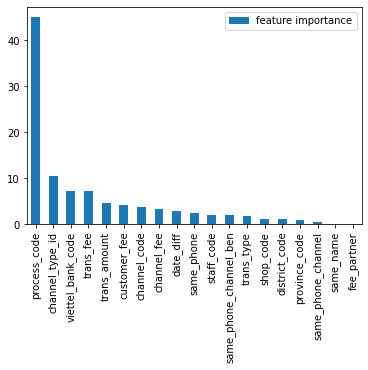

In [ ]:
df_feature_importance.plot(kind='bar');

In [ ]:
def plot_feature_importance(model, features):
    feature_importances = pd.DataFrame(sorted(zip(model.feature_importances_, features)), columns=['Value', 'Feature'])
    plt.figure(figsize=(20,10))
    sns.barplot(x="Value", y="Feature", data=feature_importances.sort_values(by="Value", ascending=False).iloc[:50])
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.show()

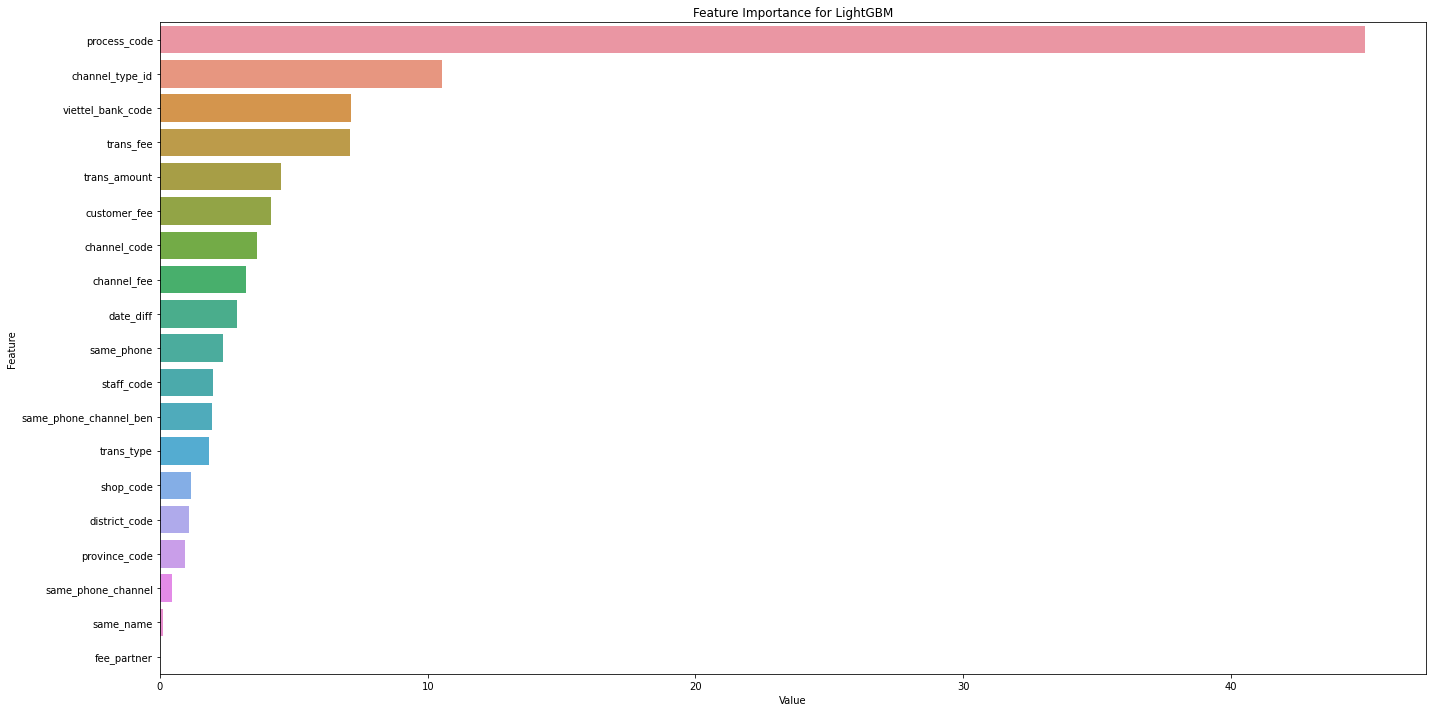

In [ ]:
plot_feature_importance(loaded_cat_model, feature_names)